# Evaluating classification models

In this notebook we will learn about ways of evaluating classification models. Here's the methods we will see:

I- Binary classification:

    1- Binary classification parameters
    2- ROC curve
    
II- Multiclass classificatin:

    1- ROC curve
    2- Confusion Matrix

#### Binary classification

Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from itertools import cycle
from scipy import interp

from ConfusionMatrix import plot_confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

Binary classification parameters:

Precision, also known as True Positive Rate:

    TPR = TP / P, where TP is number of True Positive and P is number of all Positive
    In other words, the precision is the probability of catching a positive.
    
Recall, also known as False Positive Rate:

    FPR = FP / N, where FP is number of False Positive and N is number of all Negative
    In other words, recall is the probability of missing a negative

Loading the breast cancer dataset from sklearn

In [18]:
breast_cancer = datasets.load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
list(breast_cancer.target_names)


random_state = np.random.RandomState(0)
n_samples, n_features = data.shape

We will use Gaussian Naive Bayes as our binary classifier since it is fast with high dimensions

In [19]:
gnb = GaussianNB()
score_gnb = cross_val_score(gnb, data, target, cv=10)
print score_gnb

[0.94827586 0.87931034 0.89473684 0.92982456 0.94736842 0.98245614
 0.92982456 0.96428571 0.94642857 0.96428571]


Classification parameters

In [20]:
# Splitting the dataset
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.4)

gnb = GaussianNB()
gnb.fit(data_train, target_train)

# Let's predic on the test
target_predicted = gnb.predict(data_test)

# Calculating TPR and FPR
P = sum(target_test)
N = target_test.size - P

TP = sum(target_predicted * target_test)
FP = np.where( (target_test - target_predicted) < 0 )[0].size

TPR = float(TP) / P
FPR = float(FP) / N

print "Precision: ", TPR
print "Recall: ", FPR

Precision:  0.972789115646
Recall:  0.123456790123


ROC

In [21]:
def plot_roc_binary(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Plotting the ROC curve

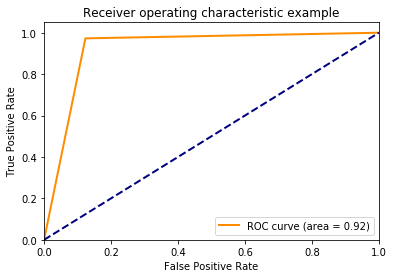

In [22]:
fpr0, tpr0, t = roc_curve(target_test, target_predicted)
roc_auc = auc(fpr0, tpr0)
plot_roc_binary(fpr0, tpr0)

### Multiclass classification

In [23]:
iris = datasets.load_iris()
print "Number of features", iris.data.shape[1]
print "Number of lables", np.unique(iris.target).shape[0]

X = iris.data
y = iris.target

# Binarize the output
lb = LabelBinarizer()
lb.fit([0,1,2])
y = lb.transform(y)
# Transforms the 3 labels classification problem to 3 binary classification problems (one vs all)
n_classes = y.shape[1]

Number of features 4
Number of lables 3


Adding noise to the data

In [24]:
# Adding 200 noisy features to make the problem harder, because iris dataset is easy to study.
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Splitting the data to training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

ROC Curve

On the ROC curve, we plot the points (FPR, TPR) for different thresholds, going from 0 to 1.

One Vs Rest Classification

In [25]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
# training the data
classifier.fit(X_train, y_train)

# testing the data
y_predicted = classifier.decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = {} # False Positive Rate
tpr = {} # True Positive Rate 
roc_auc = {} # Area under the curve

for i in range(n_classes):
    fpr[i], tpr[i], t = roc_curve(y_test[:, i], y_predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], t = roc_curve(y_test.ravel(), y_predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

Multiclass ROC curve

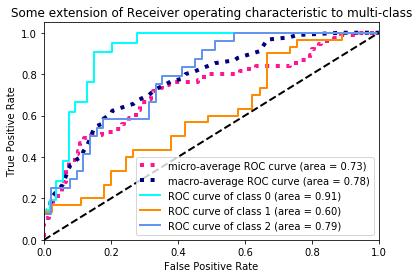

In [26]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw=2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix

In [27]:
y_predicted_labels = lb.inverse_transform(y_predicted)
y_true_labels = lb.inverse_transform(y_test)

Confusion matrix, without normalization


array([[18,  0,  3],
       [ 8, 11, 11],
       [ 3,  5, 16]], dtype=int64)

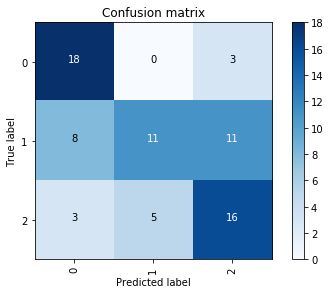

In [28]:
plot_confusion_matrix(y_predicted_labels, y_true_labels)

Notice the match in accuracy between the confusion matrix and the roc plots for each label!